In [7]:
import pandas as pd

# Set display options to see more columns
pd.set_option('display.max_columns', None)

try:
    df_agencies = pd.read_csv('agencies.csv')
    df_incident = pd.read_csv('NIBRS_incident.csv', dtype={10: 'str'})
    df_arrestee = pd.read_csv('NIBRS_ARRESTEE.csv')
    
    print(f"Agencies: {df_agencies.shape}")
    print(f"Incidents: {df_incident.shape}")
    print(f"Arrestees: {df_arrestee.shape}")

    # --- Step 1: Merge Incidents with Agencies ---
    agency_cols = ['agency_id', 'population', 'county_name', 'msa_name', 'agency_type_name']
    df_incident_agency = pd.merge(df_incident, df_agencies[agency_cols], on='agency_id', how='left')
    
    print(f"\nShape after merging incidents and agencies: {df_incident_agency.shape}")

    # --- Step 2: Merge the result with Arrestees ---
    df_master = pd.merge(df_incident_agency, df_arrestee, on='incident_id', how='inner')
    df_master = df_master.rename(columns={'data_year_x': 'incident_data_year', 'data_year_y': 'arrest_data_year'})
    print(f"Final Shape: {df_master.shape}")
   

    
    print("\n--- Master Dataset Head (First 5 Rows) ---")
    print(df_master.head())
    
    print("\n--- Master Dataset Info (Columns & Data Types) ---")
    df_master.info()

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
except Exception as e:
    print(f"An error occurred during the merge: {e}")

Agencies: (194, 59)
Incidents: (688700, 15)
Arrestees: (249291, 18)

Shape after merging incidents and agencies: (688700, 19)
Final Shape: (249291, 36)

--- Master Dataset Head (First 5 Rows) ---
   incident_data_year  agency_id  incident_id  nibrs_month_id  \
0                2024      12939    207185452        44800455   
1                2024      12939    190036004        44800455   
2                2024      12939    188477113        44800455   
3                2024      12939    197473730        44800455   
4                2024      12939    197473730        44800455   

  cargo_theft_flag          submission_date incident_date report_date_flag  \
0                f  2025-03-12 19:28:37.314    2024-01-01                f   
1                f  2024-05-01 12:36:59.498    2024-01-01                f   
2                f  2024-03-28 14:53:04.457    2024-01-02                f   
3                f  2024-09-18 17:59:24.618    2024-01-02                f   
4                f  202

In [15]:
df = df_master.copy()

print("--- Starting Data Cleaning ---")

# --- 1. Drop Empty & Redundant Columns ---
cols_to_drop = [
    'cleared_except_date',      
    'data_home',                
    'clearance_ind',            
    'age_range_high_num',       
    'age_range_low_num'         
]

cols_to_drop.extend(['submission_date', 'nibrs_month_id'])

df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped {len(cols_to_drop)} empty/redundant columns.")
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')
df['arrest_date'] = pd.to_datetime(df['arrest_date'], errors='coerce')
print("Converted 'incident_date' and 'arrest_date' to datetime objects.")
hour_mode = df['incident_hour'].mode()[0]
df['incident_hour'].fillna(hour_mode, inplace=True)
df['incident_hour'] = df['incident_hour'].astype(int)
df['resident_code'].fillna('Unknown', inplace=True)
df['under_18_disposition_code'].fillna('N/A', inplace=True)

print("Filled missing values in 'incident_hour', 'resident_code', etc.")
print("\n--- Cleaning Complete ---")
print("New DataFrame shape:", df.shape)

print("\n--- New Data Info ---")
df.info()

print("\n--- New Data Head ---")
print(df.head())

--- Starting Data Cleaning ---
Dropped 7 empty/redundant columns.
Converted 'incident_date' and 'arrest_date' to datetime objects.
Filled missing values in 'incident_hour', 'resident_code', etc.

--- Cleaning Complete ---
New DataFrame shape: (249291, 29)

--- New Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249291 entries, 0 to 249290
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   incident_data_year         249291 non-null  int64         
 1   agency_id                  249291 non-null  int64         
 2   incident_id                249291 non-null  int64         
 3   cargo_theft_flag           249291 non-null  object        
 4   incident_date              249291 non-null  datetime64[ns]
 5   report_date_flag           249291 non-null  object        
 6   incident_hour              249291 non-null  int64         
 7   cleared_except_id          24

In [16]:

df['incident_month'] = df['incident_date'].dt.month_name()
df['incident_day_of_week'] = df['incident_date'].dt.day_name()

print("Created 'incident_month' and 'incident_day_of_week' columns.")

bins = [-1, 5, 11, 17, 23]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['incident_hour'], bins=bins, labels=labels, ordered=True)

print("Created 'time_of_day' column (Night, Morning, Afternoon, Evening).")

age_bins = [0, 17, 24, 34, 49, 64, 98]
age_labels = ['Juvenile (0-17)', 'Young Adult (18-24)', 'Adult (25-34)', 'Adult (35-49)', 'Older Adult (50-64)', 'Senior (65+)']

df['age_group'] = pd.cut(df['age_num'], bins=age_bins, labels=age_labels, right=True)

df['age_group'] = df['age_group'].astype(str).replace('nan', 'Unknown')

print("Created 'age_group' column.")


df['days_to_arrest'] = (df['arrest_date'] - df['incident_date']).dt.days

df['days_to_arrest'] = df['days_to_arrest'].clip(lower=0)

print("Created 'days_to_arrest' column.")


# --- 5. Final Check ---
print("\n--- Feature Engineering Complete ---")
print("New DataFrame shape:", df.shape)

print("\n--- Check New Columns (Head) ---")
# See the new columns on the far right
print(df.head())

Created 'incident_month' and 'incident_day_of_week' columns.
Created 'time_of_day' column (Night, Morning, Afternoon, Evening).
Created 'age_group' column.
Created 'days_to_arrest' column.

--- Feature Engineering Complete ---
New DataFrame shape: (249291, 34)

--- Check New Columns (Head) ---
   incident_data_year  agency_id  incident_id cargo_theft_flag incident_date  \
0                2024      12939    207185452                f    2024-01-01   
1                2024      12939    190036004                f    2024-01-01   
2                2024      12939    188477113                f    2024-01-02   
3                2024      12939    197473730                f    2024-01-02   
4                2024      12939    197473730                f    2024-01-02   

  report_date_flag  incident_hour  cleared_except_id incident_status  \
0                f              0                  6        ACCEPTED   
1                f              5                  6        ACCEPTED   
2       


--- Plotting: Incidents by Time of Day ---


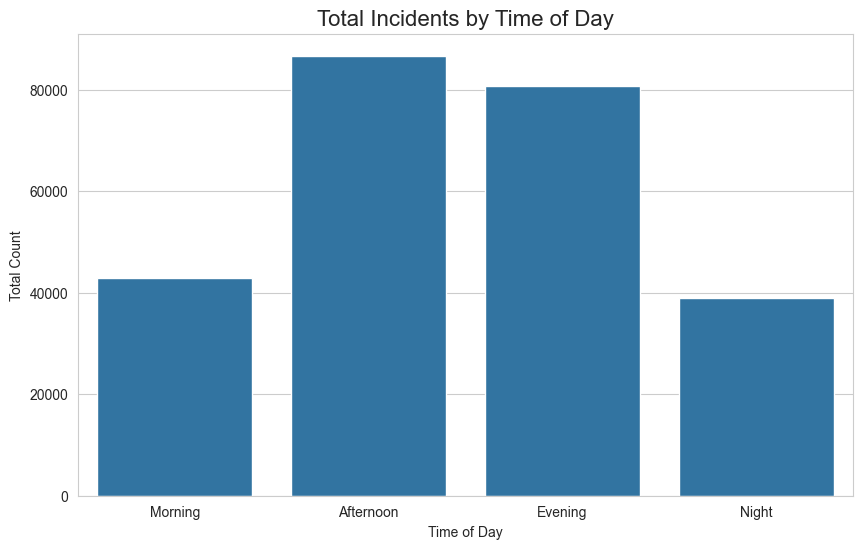


--- Plotting: Incidents by Day of Week ---


/var/folders/xb/f76wfk4n4wzg36zbg2mw1hhc0000gn/T/ipykernel_29797/1758761967.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='incident_day_of_week', order=day_order, palette='viridis')


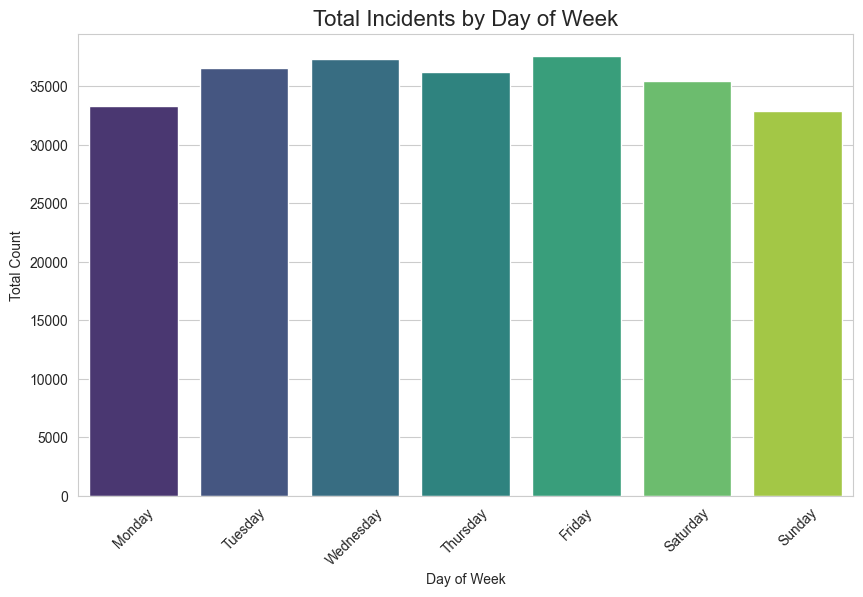


--- Plotting: Arrestees by Age Group ---


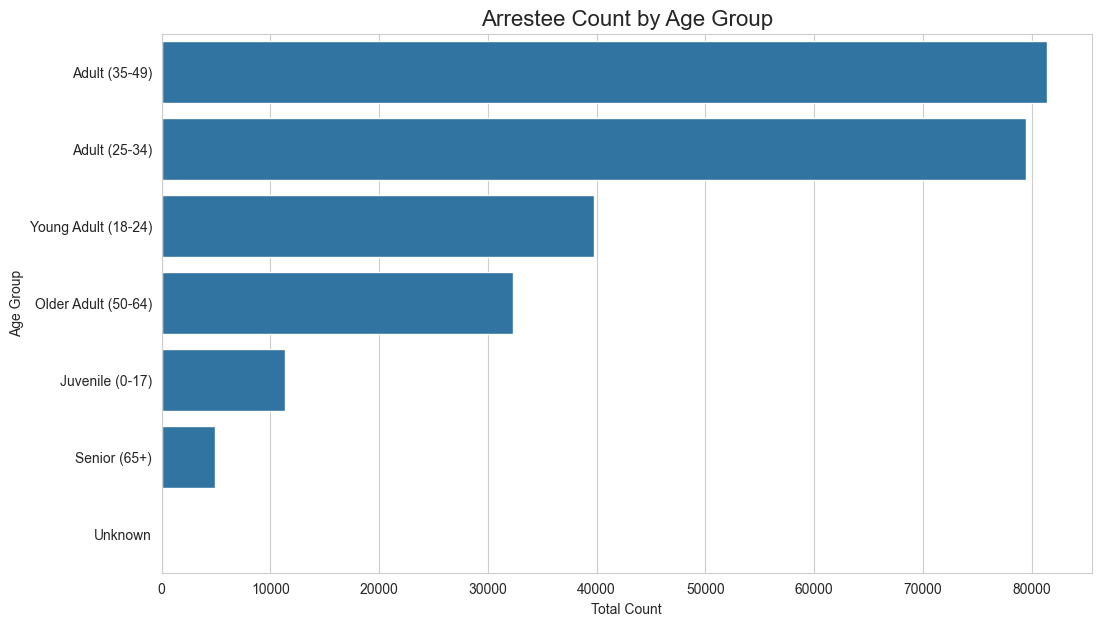


--- Plotting: Distribution of Days to Arrest (First 30 Days) ---


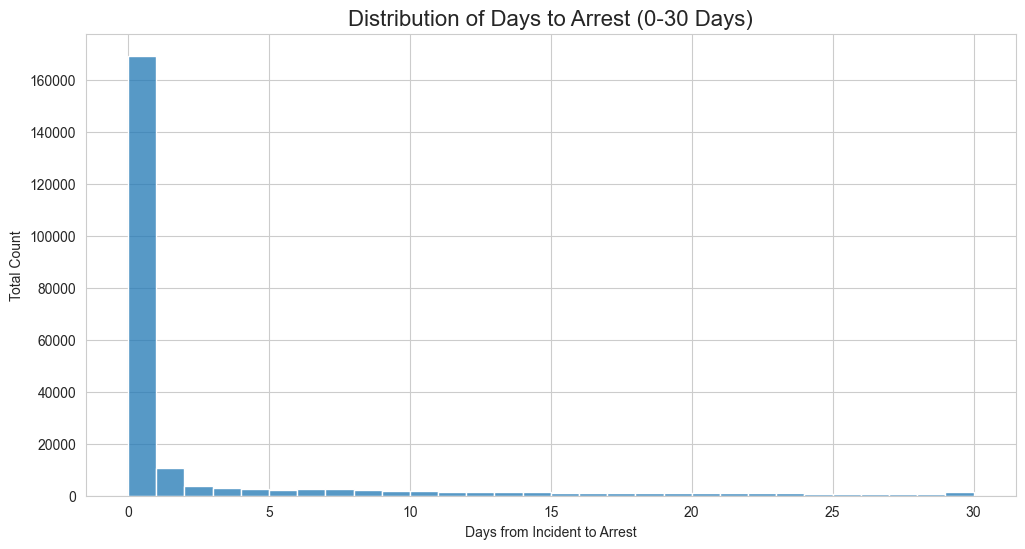

In [9]:
#  EDA : Part 1
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for our plots
sns.set_style("whitegrid")

# --- 1. When do incidents happen? (Time of Day) ---
print("\n--- Plotting: Incidents by Time of Day ---")

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='time_of_day', order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Total Incidents by Time of Day', fontsize=16)
plt.xlabel('Time of Day')
plt.ylabel('Total Count')
plt.show()


# --- 2. When do incidents happen? (Day of Week) ---
print("\n--- Plotting: Incidents by Day of Week ---")
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='incident_day_of_week', order=day_order, palette='viridis')
plt.title('Total Incidents by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.show()


# --- 3. Who is being arrested? (Age Group) ---
print("\n--- Plotting: Arrestees by Age Group ---")

plt.figure(figsize=(12, 7))
# We use 'age_group' and get the order from value_counts() to show most frequent first
sns.countplot(data=df, y='age_group', order=df['age_group'].value_counts().index)
plt.title('Arrestee Count by Age Group', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('Age Group')
plt.show()


# --- 4. How long does an arrest take? (Days to Arrest) ---
print("\n--- Plotting: Distribution of Days to Arrest (First 30 Days) ---")

# Most arrests happen quickly. Let's look at the first 30 days.
df_quick_arrests = df[df['days_to_arrest'] <= 30]

plt.figure(figsize=(12, 6))
sns.histplot(df_quick_arrests['days_to_arrest'], bins=30, kde=False)
plt.title('Distribution of Days to Arrest (0-30 Days)', fontsize=16)
plt.xlabel('Days from Incident to Arrest')
plt.ylabel('Total Count')
plt.show()


--- Plotting: Top 10 Offense Codes ---


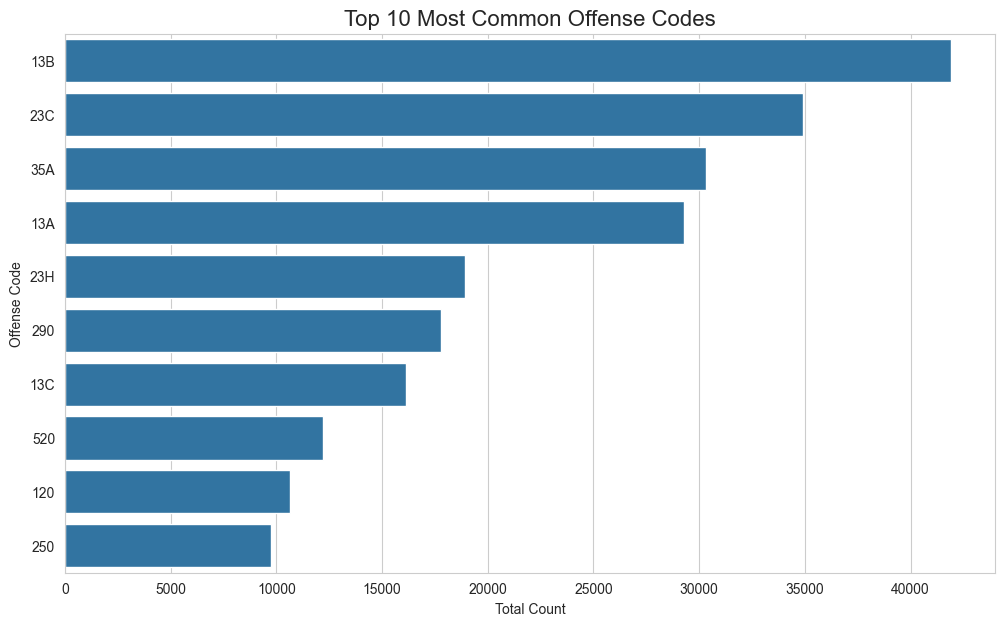


--- Plotting: Top 10 Counties by Incident Count ---


/var/folders/xb/f76wfk4n4wzg36zbg2mw1hhc0000gn/T/ipykernel_29797/3761429713.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='county_name', order=top_10_counties, palette='plasma')


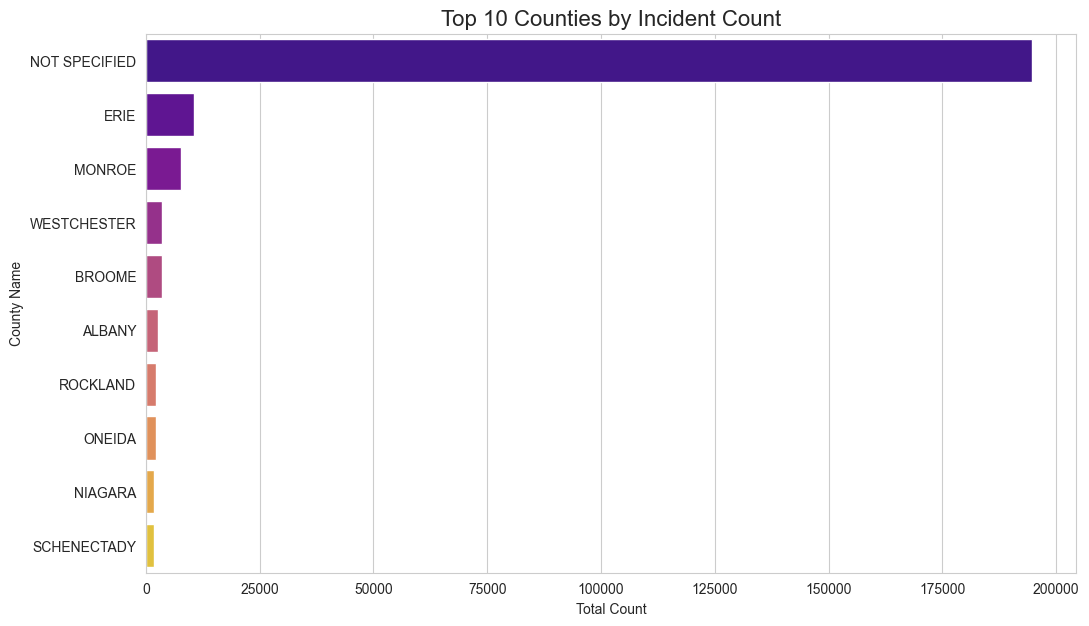


--- Plotting: Heatmap of Top Crimes by Time of Day ---


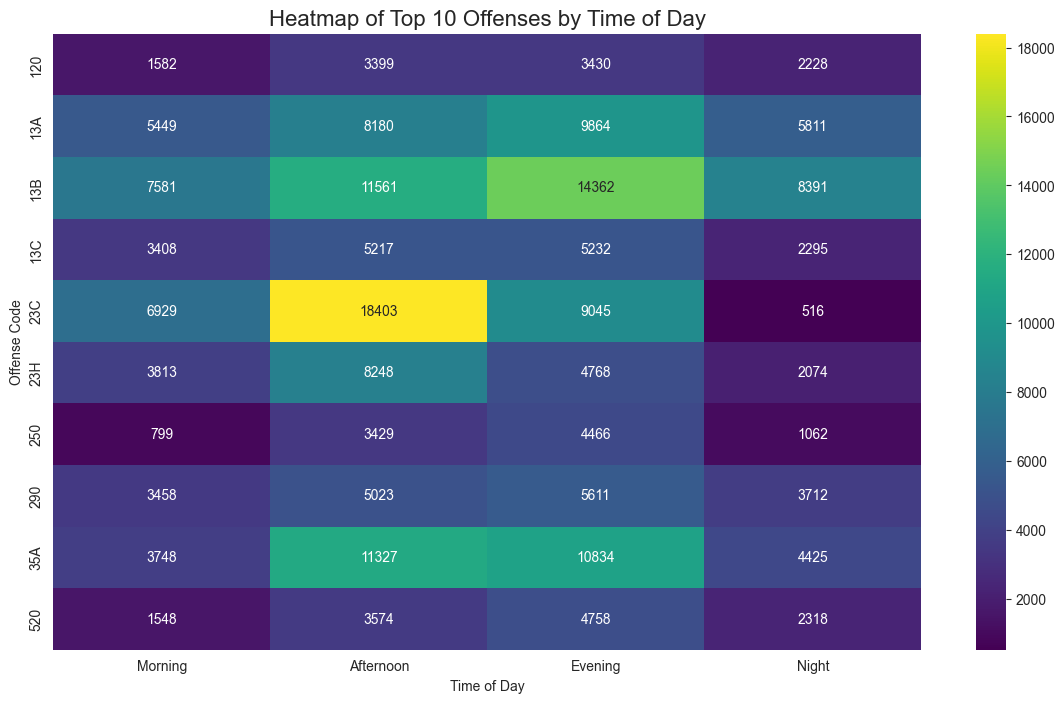

In [11]:
##  EDA : Part 2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. What are the Top 10 Most Common Offenses? ---
print("\n--- Plotting: Top 10 Offense Codes ---")

# Get the top 10 most frequent offense codes
top_10_offenses = df['offense_code'].value_counts().head(10).index

plt.figure(figsize=(12, 7))
sns.countplot(data=df, y='offense_code', order=top_10_offenses)
plt.title('Top 10 Most Common Offense Codes', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('Offense Code')
plt.show()


# --- 2. Where are Incidents Occurring? (Top 10 Counties) ---
print("\n--- Plotting: Top 10 Counties by Incident Count ---")

# Get the top 10 counties by incident count
top_10_counties = df['county_name'].value_counts().head(10).index

plt.figure(figsize=(12, 7))
sns.countplot(data=df, y='county_name', order=top_10_counties, palette='plasma')
plt.title('Top 10 Counties by Incident Count', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('County Name')
plt.show()


# --- 3. What is the relationship between Time of Day and Top Crimes? ---
print("\n--- Plotting: Heatmap of Top Crimes by Time of Day ---")

# Filter our dataframe to only include the top 10 offenses
df_top10_offenses = df[df['offense_code'].isin(top_10_offenses)]

# Create a "crosstab" (a frequency table) of time_of_day vs. offense_code
crime_by_time = pd.crosstab(df_top10_offenses['offense_code'], df_top10_offenses['time_of_day'])

# Re-order the columns logically
crime_by_time = crime_by_time[['Morning', 'Afternoon', 'Evening', 'Night']]

# Draw the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(crime_by_time, cmap='viridis', annot=True, fmt='d') # 'annot=True' shows the numbers, 'fmt="d"' makes them integers
plt.title('Heatmap of Top 10 Offenses by Time of Day', fontsize=16)
plt.xlabel('Time of Day')
plt.ylabel('Offense Code')
plt.show()

--- Plotting: Age Group Distribution for Top 10 Offenses ---


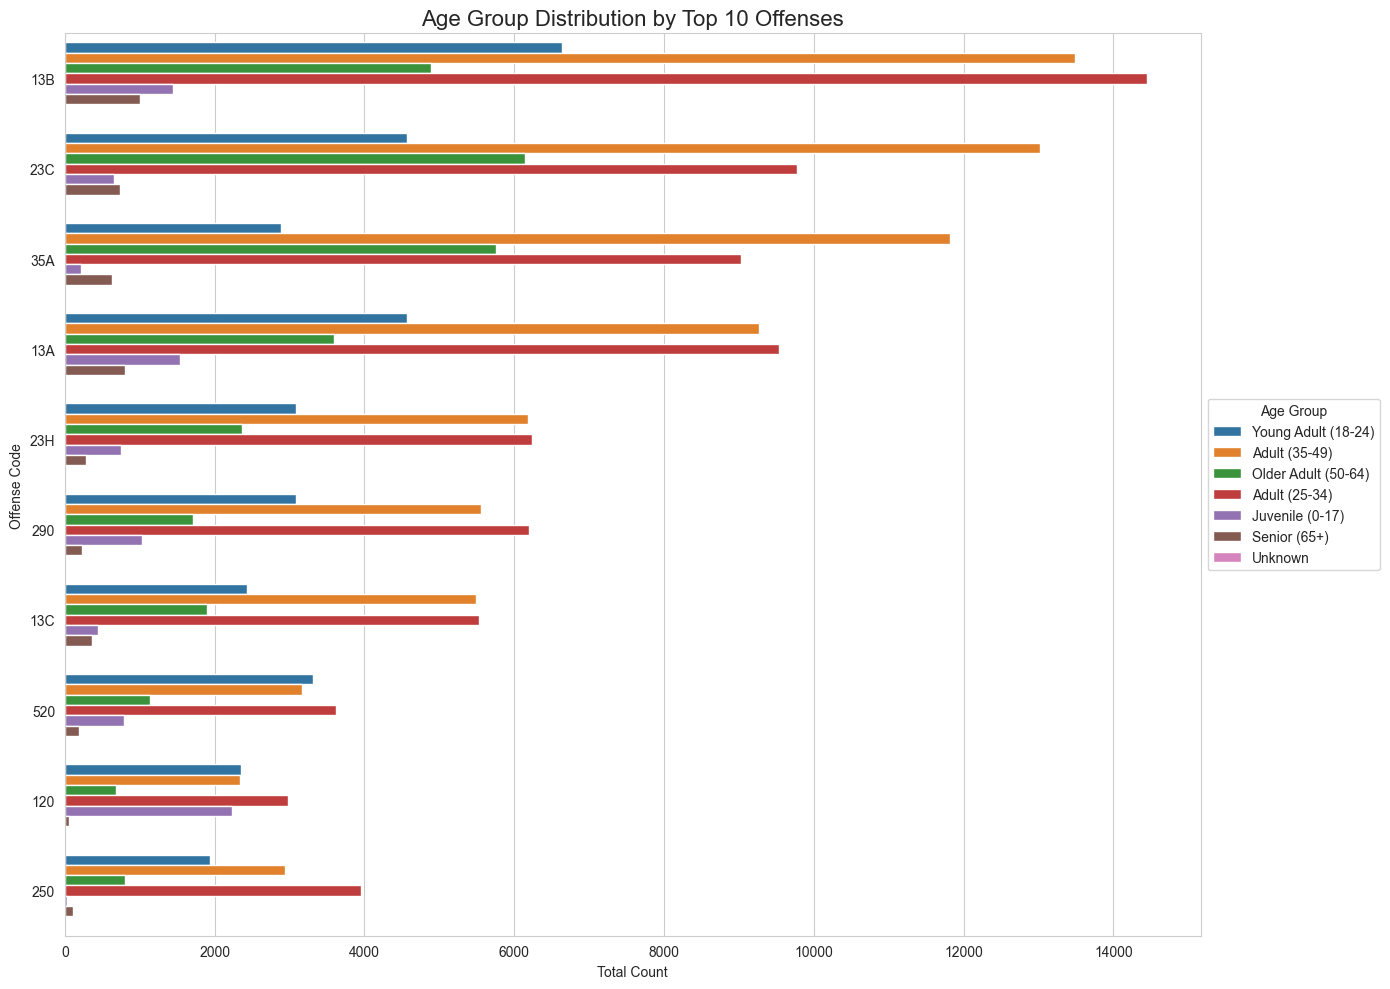


--- Plotting: Sex Distribution for Top 10 Offenses ---


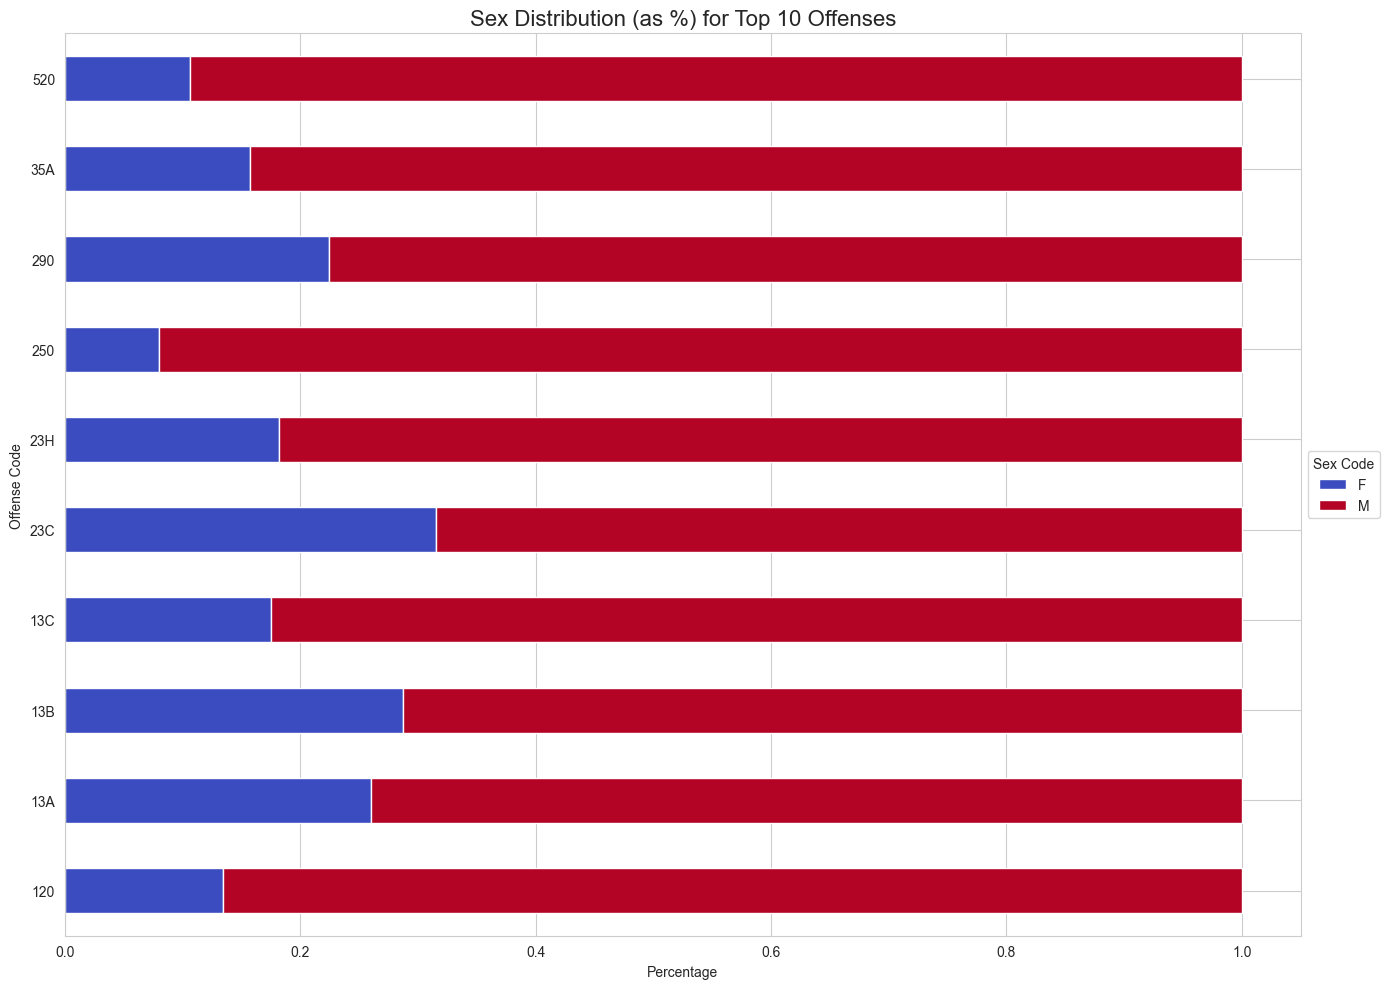

In [12]:
#EDA part 3
import seaborn as sns
import matplotlib.pyplot as plt
# Filter the DataFrame to only include these top offenses
df_top10_offenses = df[df['offense_code'].isin(top_10_offenses)]

print("--- Plotting: Age Group Distribution for Top 10 Offenses ---")

plt.figure(figsize=(14, 10))
sns.countplot(
    data=df_top10_offenses,
    y='offense_code',
    hue='age_group', # This creates the breakdown
    order=top_10_offenses
)
plt.title('Age Group Distribution by Top 10 Offenses', fontsize=16)
plt.xlabel('Total Count')
plt.ylabel('Offense Code')
plt.legend(title='Age Group', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout() # Adjusts plot to prevent legend cutoff
plt.show()
crosstab_sex = pd.crosstab(
    df_top10_offenses['offense_code'],
    df_top10_offenses['sex_code'],
    normalize='index' # This calculates percentage by row
)


crosstab_sex.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 10),
    colormap='coolwarm'
)
plt.title('Sex Distribution (as %) for Top 10 Offenses', fontsize=16)
plt.xlabel('Percentage')
plt.ylabel('Offense Code')
plt.legend(title='Sex Code', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

--- Starting Crime Rate Analysis ---
Calculated total population for each county.
Calculated total incidents for each county.
Calculated crime rate per 100,000 people.


/var/folders/xb/f76wfk4n4wzg36zbg2mw1hhc0000gn/T/ipykernel_29797/1261383875.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


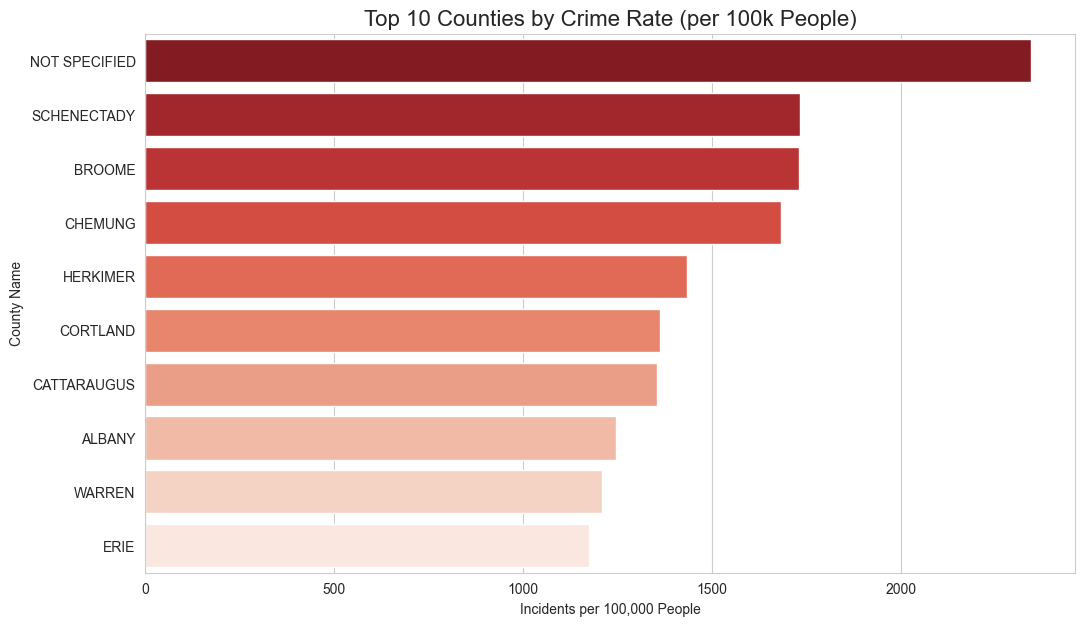


--- For Comparison: Top 10 by RAW COUNT ---
county_name
NOT SPECIFIED    194623
ERIE              10493
MONROE             7677
WESTCHESTER        3545
BROOME             3435
ALBANY             2720
ROCKLAND           2327
ONEIDA             2242
NIAGARA            1807
SCHENECTADY        1717
Name: count, dtype: int64

--- Top 10 by CRIME RATE ---
      county_name  rate_per_100k  incident_count  total_county_population
0   NOT SPECIFIED    2345.061392          194623                  8299271
9     SCHENECTADY    1732.103946            1717                    99128
4          BROOME    1731.080325            3435                   198431
11        CHEMUNG    1683.749131            1283                    76199
38       HERKIMER    1433.691756             108                     7533
22       CORTLAND    1362.913281             634                    46518
16    CATTARAUGUS    1354.344662             856                    63204
5          ALBANY    1246.254364            2720       

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("--- Starting Crime Rate Analysis ---")

# --- 1. Get County Population ---
try:
    county_populations = df_agencies.groupby('county_name')['population'].sum().reset_index()
    county_populations = county_populations.rename(columns={'population': 'total_county_population'})
    print("Calculated total population for each county.")
    
except NameError:
    print("Error: 'df_agencies' not found. Please re-load your 'agencies.csv' file.")
    raise

# --- 2. Get County Incident Counts ---
county_incidents = df['county_name'].value_counts().reset_index()
county_incidents.columns = ['county_name', 'incident_count']
print("Calculated total incidents for each county.")

# --- 3. Merge Population and Incidents ---
county_stats = pd.merge(county_incidents, county_populations, on='county_name', how='left')

# --- 4. Calculate Crime Rate ---
county_stats = county_stats[county_stats['total_county_population'] > 0]
county_stats['rate_per_100k'] = (county_stats['incident_count'] / county_stats['total_county_population']) * 100000
print("Calculated crime rate per 100,000 people.")

# --- 5. Plot Top 10 Counties by Crime Rate ---
top_10_rate_counties = county_stats.sort_values('rate_per_100k', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10_rate_counties,
    x='rate_per_100k',
    y='county_name',
    palette='Reds_r'
)
plt.title('Top 10 Counties by Crime Rate (per 100k People)', fontsize=16)
plt.xlabel('Incidents per 100,000 People')
plt.ylabel('County Name')
plt.show()

# You can also compare this to the raw count
print("\n--- For Comparison: Top 10 by RAW COUNT ---")
print(df['county_name'].value_counts().head(10))

print("\n--- Top 10 by CRIME RATE ---")
print(top_10_rate_counties[['county_name', 'rate_per_100k', 'incident_count', 'total_county_population']])

--- Plotting: 'Days to Arrest' Distribution for Top 10 Offenses ---


/var/folders/xb/f76wfk4n4wzg36zbg2mw1hhc0000gn/T/ipykernel_29797/1754804882.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


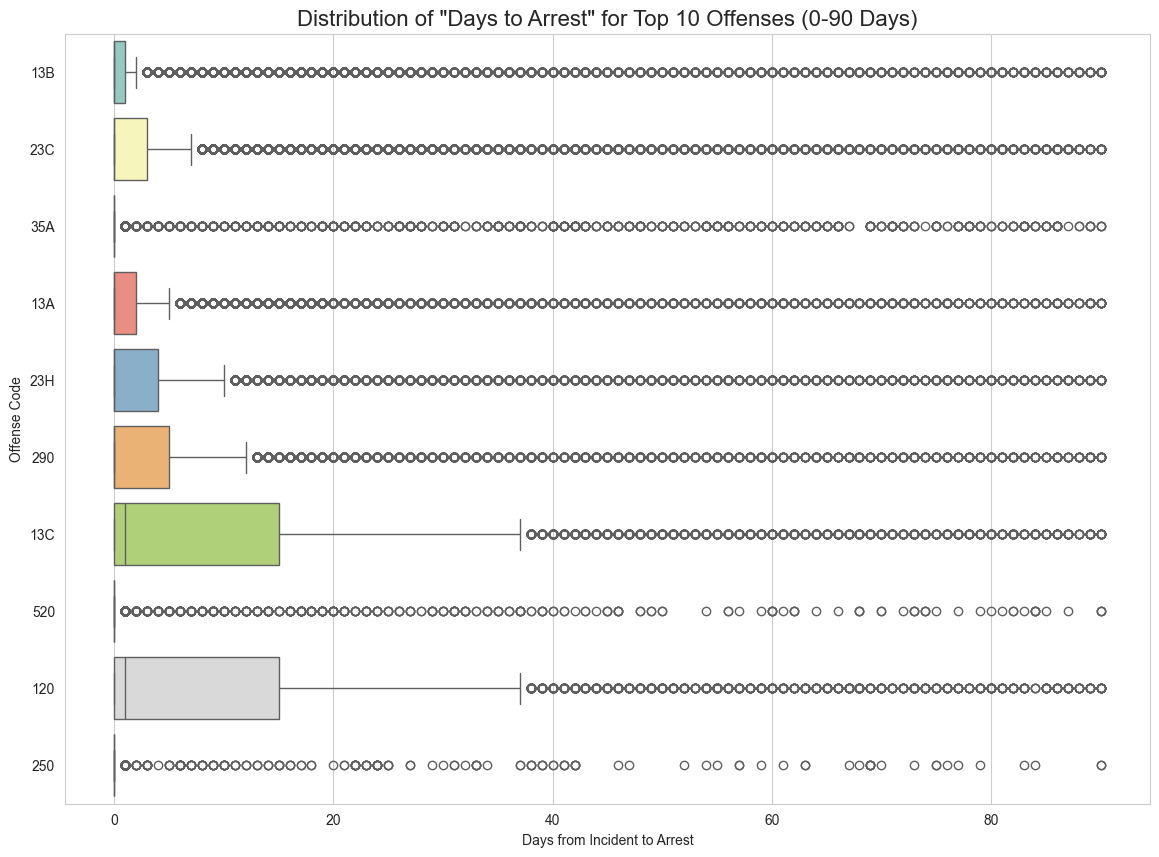


--- Median 'Days to Arrest' for Top 10 Offenses ---
offense_code
13A    0.0
13B    0.0
23C    0.0
23H    0.0
250    0.0
290    0.0
35A    0.0
520    0.0
120    2.0
13C    2.0
Name: days_to_arrest, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_top10 = df[df['offense_code'].isin(top_10_offenses)]

print("--- Plotting: 'Days to Arrest' Distribution for Top 10 Offenses ---")
df_plot = df_top10[df_top10['days_to_arrest'] <= 90]

# --- 3. Create the Boxplot ---
plt.figure(figsize=(14, 10))
sns.boxplot(
    data=df_plot,
    x='days_to_arrest',
    y='offense_code',
    order=top_10_offenses, 
    palette='Set3'
)
plt.title('Distribution of "Days to Arrest" for Top 10 Offenses (0-90 Days)', fontsize=16)
plt.xlabel('Days from Incident to Arrest')
plt.ylabel('Offense Code')
plt.show()

print("\n--- Median 'Days to Arrest' for Top 10 Offenses ---")
median_arrest_time = df_top10.groupby('offense_code')['days_to_arrest'].median().sort_values()
print(median_arrest_time)

In [9]:
agencies_ny = df_agencies[df_agencies["state_abbr"] == "NY"].copy()


In [10]:
agencies_ny


,yearly_agency_id,agency_id,data_year,ori,legacy_ori,covered_by_legacy_ori,direct_contributor_flag,dormant_flag,dormant_year,reporting_type,ucr_agency_name,ncic_agency_name,pub_agency_name,pub_agency_unit,agency_status,state_id,state_name,state_abbr,state_postal_abbr,division_code,division_name,region_code,region_name,region_desc,agency_type_name,population,submitting_agency_id,sai,submitting_agency_name,suburban_area_flag,population_group_id,population_group_code,population_group_desc,parent_pop_group_code,parent_pop_group_desc,mip_flag,pop_sort_order,summary_rape_def,pe_reported_flag,male_officer,male_civilian,male_officer+male_civilian,female_officer,female_civilian,female_officer+female_civilian,officer_rate,employee_rate,nibrs_cert_date,nibrs_start_date,nibrs_leoka_start_date,nibrs_ct_start_date,nibrs_multi_bias_start_date,nibrs_off_eth_start_date,covered_flag,county_name,msa_name,publishable_flag,participated,nibrs_participated
0,129392024,12939,2024,NY0010100,NY0010100,NaN,N,N,NaN,I,ALBANY,ALBANY CITY PD ALBANY,Albany,NaN,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,City,102095,23384,NYUCR0001,New York State Division of Criminal Justice Se...,N,6,2,"Cities from 100,000 thru 249,999",2,"Cities from 100,000 thru 249,999",Y,6,NaN,Y,243.0,36.0,279.0,25.0,38.0,63.0,2.6,3.3,2019-01-01,2020-11-01,2021-01-01,2021-01-01,2021-01-01,2021-01-01,N,ALBANY,"Albany-Schenectady-Troy, NY",Y,Y,Y
1,129462024,12946,2024,NY0015100,NY0015100,NaN,N,N,NaN,I,BETHLEHEM TOWN,BETHLEHEM TOWN PD DELMAR,Bethlehem Town,NaN,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,City,34933,23384,NYUCR0001,New York State Division of Criminal Justice Se...,Y,8,4,"Cities from 25,000 thru 49,999",4,"Cities from 25,000 thru 49,999",N,8,NaN,Y,31.0,6.0,37.0,5.0,11.0,16.0,1.0,1.5,2019-01-01,2021-01-01,2021-01-01,2021-01-01,2021-01-01,2021-01-01,N,ALBANY,"Albany-Schenectady-Troy, NY",Y,Y,Y
2,129482024,12948,2024,NY0015300,NY0015300,NaN,N,N,NaN,I,COLONIE TOWN,COLONIE TOWN PD LATHAM,Colonie Town,NaN,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,City,81226,23384,NYUCR0001,New York State Division of Criminal Justice Se...,N,7,3,"Cities from 50,000 thru 99,999",3,"Cities from 50,000 thru 99,999",N,7,NaN,Y,106.0,25.0,131.0,9.0,16.0,25.0,1.4,1.9,2019-01-01,2021-01-01,2021-01-01,2021-01-01,2021-01-01,2021-01-01,N,ALBANY,"Albany-Schenectady-Troy, NY",Y,Y,Y
3,129682024,12968,2024,NY0030000,NY0030000,NaN,N,N,NaN,I,BROOME,BROOME CO SHERIFF'S DEPARTMENT BINGHAMTON,Broome,NaN,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,County,91944,23384,NYUCR0001,New York State Division of Criminal Justice Se...,Y,20,9B,"MSA counties from 25,000 thru 99,999",9,MSA Counties,N,20,NaN,Y,89.0,6.0,95.0,3.0,12.0,15.0,1.0,1.2,2019-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,N,BROOME,"Binghamton, NY",Y,Y,Y
4,129692024,12969,2024,NY0030100,NY0030100,NaN,N,N,NaN,I,BINGHAMTON,BINGHAMTON CITY PD BINGHAMTON,Binghamton,NaN,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,City,46378,23384,NYUCR0001,New York State Division of Criminal Justice Se...,N,8,4,"Cities from 25,000 thru 49,999",4,"Cities from 25,000 thru 49,999",N,8,NaN,Y,125.0,2.0,127.0,10.0,10.0,20.0,2.9,3.2,2019-01-01,2019-01-01,2019-01-01,2020-01-01,2020-01-01,2020-01-01,N,BROOME,"Binghamton, NY",Y,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,136972024,13697,2024,NY255UN00,NY255UN00,NaN,N,N,NaN,I,SUNY POLICE: NEW PALTZ,SUNY COLLEGE: NEW PALTZ,State University of New York Police:,New Paltz,A,38,New York,NY,NY,2,Middle Atlantic,1,Northeast,Region I,University or College,0,23384,NYUCR0001,New York State Division of Criminal Justice Se...,Y,11,7,"Cities under 2,500",7,"Cities under 2,500",N,11,NaN,Y,14.0,0.0,14.0,6.0,5.0,11.0,0.0,0.0,2019-01-01,2021-01-01,2021-01-01,2021-01-01,2

In [19]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

# === Your same variable names ===
df_agencies = pd.read_csv("agencies.csv")
df_incident = pd.read_csv("NIBRS_incident.csv", dtype={10:"str"}, low_memory=False)
df_arrestee = pd.read_csv("NIBRS_ARRESTEE.csv", low_memory=False)

# Extra tables for Phase 6+ features
df_offense = pd.read_csv("NIBRS_OFFENSE.csv", low_memory=False)
df_offense_type = pd.read_csv("NIBRS_OFFENSE_TYPE.csv", low_memory=False)
df_victim = pd.read_csv("NIBRS_VICTIM.csv", low_memory=False)

print("Agencies:", df_agencies.shape)
print("Incidents:", df_incident.shape)
print("Arrestees:", df_arrestee.shape)
print("Offense:", df_offense.shape)
print("Offense_type:", df_offense_type.shape)
print("Victim:", df_victim.shape)

# --- Step 1: Merge Incidents with Agencies (your approach) ---
agency_cols = ["agency_id", "population", "county_name", "msa_name", "agency_type_name"]
agency_cols = [c for c in agency_cols if c in df_agencies.columns]

df_incident_agency = pd.merge(df_incident, df_agencies[agency_cols], on="agency_id", how="left")
print("Shape after incidents+agencies:", df_incident_agency.shape)

# --- Step 2: Merge with Arrestees (your approach) ---
# IMPORTANT: this is ONLY for arrest-related features, not total crime counts
df_master = pd.merge(df_incident_agency, df_arrestee, on="incident_id", how="inner")
df_master = df_master.rename(columns={"data_year_x":"incident_data_year", "data_year_y":"arrest_data_year"})
print("df_master (arrested incidents only):", df_master.shape)


Agencies: (194, 59)
Incidents: (688700, 15)
Arrestees: (249291, 18)
Offense: (778149, 8)
Offense_type: (86, 8)
Victim: (725839, 16)
Shape after incidents+agencies: (688700, 19)
df_master (arrested incidents only): (249291, 36)


In [20]:
# Parse dates
df_incident_agency["incident_date"] = pd.to_datetime(df_incident_agency["incident_date"], errors="coerce")

# Use ALL incidents (not df_master) for counts
inc_all = df_incident_agency.dropna(subset=["incident_id","county_name","incident_date"])[
    ["incident_id","county_name","incident_date"]
].drop_duplicates()

# Week index
inc_all["week"] = inc_all["incident_date"].dt.to_period("W").dt.start_time

# County-week incident counts
county_week = (inc_all.groupby(["county_name","week"])
               .size().reset_index(name="incidents"))

# County population proxy (max across agencies in county)
county_pop = (df_agencies.groupby("county_name")["population"]
              .max().rename("county_population").reset_index())

county_week = county_week.merge(county_pop, on="county_name", how="left")
county_week["county_population"] = pd.to_numeric(county_week["county_population"], errors="coerce")
county_week.loc[county_week["county_population"] <= 0, "county_population"] = np.nan

# Normalized rate
county_week["rate_per_100k"] = county_week["incidents"] / county_week["county_population"] * 100000

county_week = county_week.sort_values(["county_name","week"]).reset_index(drop=True)
county_week.head()


,county_name,week,incidents,county_population,rate_per_100k
0,ALBANY,2024-01-01,226,102095.0,221.362457
1,ALBANY,2024-01-08,234,102095.0,229.198296
2,ALBANY,2024-01-15,208,102095.0,203.731818
3,ALBANY,2024-01-22,221,102095.0,216.465057
4,ALBANY,2024-01-29,221,102095.0,216.465057


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Join offense -> incident county/week
off = df_offense.merge(inc_all[["incident_id","county_name","week"]], on="incident_id", how="inner")

# Add offense name (text)
off = off.merge(df_offense_type[["offense_code","offense_name"]], on="offense_code", how="left")

# Create one "document" per county-week
docs = (off.groupby(["county_name","week"])["offense_name"]
        .apply(lambda s: " ".join([str(x) for x in s.dropna().tolist()]))
        .reset_index(name="text"))

# TF-IDF + SVD topics
tfidf = TfidfVectorizer(min_df=3, max_df=0.9, stop_words="english", ngram_range=(1,2))
Xtxt = tfidf.fit_transform(docs["text"])

svd = TruncatedSVD(n_components=12, random_state=42)
Z = svd.fit_transform(Xtxt)

topic_cols = [f"txt_topic_{i}" for i in range(Z.shape[1])]
docs_topics = pd.concat([docs[["county_name","week"]], pd.DataFrame(Z, columns=topic_cols)], axis=1)

docs_topics.head()


,county_name,week,txt_topic_0,txt_topic_1,txt_topic_2,txt_topic_3,txt_topic_4,txt_topic_5,txt_topic_6,txt_topic_7,txt_topic_8,txt_topic_9,txt_topic_10,txt_topic_11
0,ALBANY,2024-01-01,0.837481,-0.309221,0.074919,0.218354,-0.049626,-0.078795,0.058643,0.074713,0.155516,-0.060393,0.012105,0.203374
1,ALBANY,2024-01-08,0.864465,-0.301843,0.021755,0.192485,0.072243,-0.041581,0.106789,0.053345,0.126196,-0.077084,-0.077235,0.044537
2,ALBANY,2024-01-15,0.815803,-0.350318,0.100879,0.285024,-0.016256,-0.035265,0.010690,0.129227,0.104012,-0.073907,-0.074289,0.050018
3,ALBANY,2024-01-22,0.863255,-0.342684,0.010171,0.182420,0.081092,-0.055051,0.027733,0.100863,0.037074,-0.010790,-0.049733,0.157623
4,ALBANY,2024-01-29,0.904707,-0.237293,0.043782,0.091421,0.018846,0.005941,0.067848,0.014241,0.084502,-0.058936,0.028320,0.083485


In [22]:
for lag in [1,2,3,4]:
    county_week[f"inc_lag{lag}"] = county_week.groupby("county_name")["incidents"].shift(lag)

county_week["roll4_mean"] = (county_week.groupby("county_name")["incidents"]
                             .shift(1).rolling(4).mean().reset_index(level=0, drop=True))

county_week["roll8_mean"] = (county_week.groupby("county_name")["incidents"]
                             .shift(1).rolling(8).mean().reset_index(level=0, drop=True))


In [23]:
top_codes = off["offense_code"].value_counts().head(20).index.tolist()
off_top = off[off["offense_code"].isin(top_codes)].copy()

off_pivot = (off_top.groupby(["county_name","week","offense_code"])
             .size().reset_index(name="cnt")
             .pivot_table(index=["county_name","week"], columns="offense_code", values="cnt", fill_value=0)
             .reset_index())

off_pivot.columns = ["county_name","week"] + [f"off_{c}" for c in off_pivot.columns[2:]]


In [24]:
vic = df_victim.merge(inc_all[["incident_id","county_name","week"]], on="incident_id", how="inner")

# identify victim id column
victim_id_col = "victim_id" if "victim_id" in vic.columns else [c for c in vic.columns if c.endswith("_id")][0]

vic_sex = (vic.pivot_table(index=["county_name","week"], columns="sex_code",
                           values=victim_id_col, aggfunc="count", fill_value=0)
           .reset_index())

vic_sex.columns = ["county_name","week"] + [f"victim_sex_{c}" for c in vic_sex.columns[2:]]




In [25]:
df_master["incident_date"] = pd.to_datetime(df_master["incident_date"], errors="coerce")
df_master["arrest_date"] = pd.to_datetime(df_master["arrest_date"], errors="coerce")

arr = df_master.dropna(subset=["incident_id","county_name","incident_date","arrest_date"]).copy()
arr["week"] = arr["incident_date"].dt.to_period("W").dt.start_time
arr["days_to_arrest"] = (arr["arrest_date"] - arr["incident_date"]).dt.days
arr.loc[arr["days_to_arrest"] < 0, "days_to_arrest"] = np.nan

arr_feat = (arr.groupby(["county_name","week"])
            .agg(arrests=("arrestee_id","count"),
                 avg_days_to_arrest=("days_to_arrest","mean"),
                 med_days_to_arrest=("days_to_arrest","median"))
            .reset_index())


In [26]:
df_feat = county_week.merge(off_pivot, on=["county_name","week"], how="left")
df_feat = df_feat.merge(docs_topics, on=["county_name","week"], how="left")
df_feat = df_feat.merge(vic_sex, on=["county_name","week"], how="left")
df_feat = df_feat.merge(arr_feat, on=["county_name","week"], how="left")

df_feat = df_feat.fillna(0).sort_values(["county_name","week"]).reset_index(drop=True)
df_feat.head()


,county_name,week,incidents,county_population,rate_per_100k,inc_lag1,inc_lag2,inc_lag3,inc_lag4,roll4_mean,roll8_mean,off_11A,off_11D,off_120,off_13A,off_13B,off_13C,off_220,off_23A,off_23C,off_23D,off_23F,off_23G,off_23H,off_240,off_250,off_26F,off_280,off_290,off_35A,off_520,txt_topic_0,txt_topic_1,txt_topic_2,txt_topic_3,txt_topic_4,txt_topic_5,txt_topic_6,txt_topic_7,txt_topic_8,txt_topic_9,txt_topic_10,txt_topic_11,victim_sex_F,victim_sex_M,victim_sex_U,victim_sex_X,arrests,avg_days_to_arrest,med_days_to_arrest
0,ALBANY,2024-01-01,226,102095.0,221.362457,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5.0,14.0,31.0,14.0,14.0,0.0,45.0,29.0,9.0,2.0,37.0,5.0,12.0,16.0,3.0,37.0,4.0,12.0,0.837481,-0.309221,0.074919,0.218354,-0.049626,-0.078795,0.058643,0.074713,0.155516,-0.060393,0.012105,0.203374,73,83,6,93,66.0,29.954545,0.0
1,ALBANY,2024-01-08,234,102095.0,229.198296,226.0,0.0,0.0,0.0,0.00,0.0,3.0,1.0,6.0,10.0,45.0,23.0,14.0,0.0,47.0,18.0,8.0,0.0,26.0,10.0,2.0,13.0,0.0,38.0,0.0,12.0,0.864465,-0.301843,0.021755,0.192485,0.072243,-0.041581,0.106789,0.053345,0.126196,-0.077084,-0.077235,0.044537,95,83,1,78,60.0,13.516667,0.0
2,ALBANY,2024-01-15,208,102095.0,203.731818,234.0,226.0,0.0,0.0,0.00,0.0,0.0,0.0,4.0,10.0,31.0,13.0,10.0,0.0,48.0,18.0,11.0,1.0,29.0,12.0,6.0,11.0,1.0,30.0,3.0,9.0,0.815803,-0.350318,0.100879,0.285024,-0.016256,-0.035265,0.010690,0.129227,0.104012,-0.073907,-0.074289,0.050018,77,60,7,89,35.0,36.057143,0.0
3,ALBANY,2024-01-22,221,102095.0,216.465057,208.0,234.0,226.0,0.0,0.00,0.0,2.0,0.0,6.0,5.0,46.0,15.0,10.0,0.0,43.0,23.0,10.0,4.0,27.0,4.0,5.0,16.0,1.0,40.0,2.0,5.0,0.863255,-0.342684,0.010171,0.182420,0.081092,-0.055051,0.027733,0.100863,0.037074,-0.010790,-0.049733,0.157623,85,73,6,84,44.0,48.727273,0.0
4,ALBANY,2024-01-29,221,102095.0,216.465057,221.0,208.0,234.0,226.0,222.25,0.0,0.0,1.0,6.0,10.0,39.0,27.0,11.0,1.0,34.0,13.0,10.0,0.0,30.0,4.0,3.0,16.0,4.0,39.0,7.0,11.0,0.904707,-0.237293,0.043782,0.091421,0.018846,0.005941,0.067848,0.014241,0.084502,-0.058936,0.028320,0.083485,84,79,10,72,43.0,17.209302,0.0


In [27]:
df_feat["next_incidents"] = df_feat.groupby("county_name")["incidents"].shift(-1)

thr = df_feat.groupby("county_name")["incidents"].transform(lambda s: s.quantile(0.80))
df_feat["y_hotspot"] = (df_feat["next_incidents"] >= thr).astype(int)

df_time = df_feat.dropna(subset=["next_incidents"]).sort_values("week").reset_index(drop=True)
df_time.shape


(2268, 52)

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

feature_cols = [c for c in df_time.columns if c not in
                ["county_name","week","incidents","next_incidents","y_hotspot"]]

X = df_time[feature_cols].astype(float).values
y = df_time["y_hotspot"].values

tscv = TimeSeriesSplit(n_splits=5)

base = HistGradientBoostingClassifier(random_state=42)
all_probs = np.full(len(df_time), np.nan)

briers, aucs = [], []
for tr, te in tscv.split(X):
    cal = CalibratedClassifierCV(base, method="isotonic", cv=3)
    cal.fit(X[tr], y[tr])
    p = cal.predict_proba(X[te])[:, 1]
    all_probs[te] = p
    briers.append(brier_score_loss(y[te], p))
    try:
        aucs.append(roc_auc_score(y[te], p))
    except:
        aucs.append(np.nan)

df_time["pred_p"] = all_probs

print("Mean Brier:", float(np.mean(briers)))
print("Mean AUC:", float(np.nanmean(aucs)))


Mean Brier: 0.203698825248925
Mean AUC: 0.5277170797207649


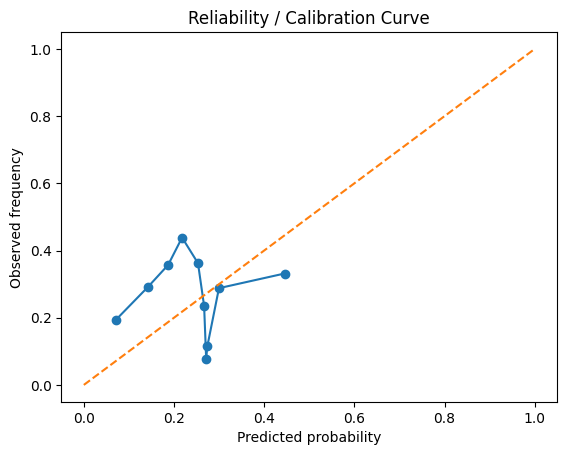

In [29]:
mask = ~np.isnan(df_time["pred_p"].values)
prob_true, prob_pred = calibration_curve(y[mask], df_time.loc[mask, "pred_p"].values,
                                         n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability / Calibration Curve")
plt.show()


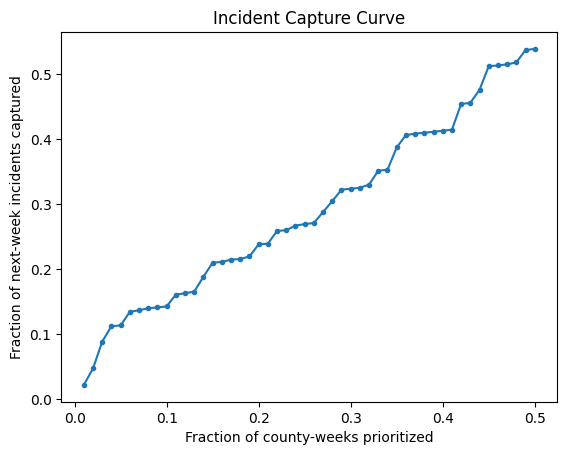

In [30]:
eval_df = df_time.dropna(subset=["pred_p"]).sort_values("pred_p", ascending=False).reset_index(drop=True)
total_future = eval_df["next_incidents"].sum()

fractions = np.linspace(0.01, 0.50, 50)
captured = []
for f in fractions:
    k = int(np.ceil(f * len(eval_df)))
    captured.append(eval_df.iloc[:k]["next_incidents"].sum() / total_future)

plt.figure()
plt.plot(fractions, captured, marker=".")
plt.xlabel("Fraction of county-weeks prioritized")
plt.ylabel("Fraction of next-week incidents captured")
plt.title("Incident Capture Curve")
plt.show()


In [33]:
df_time.to_csv("ny_county_week_features_with_predictions.csv", index=False)

latest_week = df_time["week"].max()
latest = df_time[df_time["week"] == latest_week].sort_values("pred_p", ascending=False)

latest[["county_name","week","pred_p","incidents","next_incidents","rate_per_100k"]].to_csv(
    "ny_latest_week_predictions.csv", index=False
)

df_time[["county_name","week","pred_p","incidents","next_incidents","rate_per_100k"]].to_csv(
    "ny_county_week_predictions_all.csv", index=False
)

print("Saved:")





Saved:


In [34]:
import pandas as pd
import numpy as np

# ----------------------------
# Assumes you already ran YOUR merge cell and have:
# df_agencies, df_incident, df_arrestee, df_master
# ----------------------------

# =========
# Phase 2–3: Cleaning + Feature Engineering (minimal but consistent)
# =========
df_master = df_master.copy()

# Fix missing resident_code
if "resident_code" in df_master.columns:
    df_master["resident_code"] = df_master["resident_code"].fillna("U")

# Ensure incident_hour numeric and fill missing with mode
df_master["incident_hour"] = pd.to_numeric(df_master["incident_hour"], errors="coerce")
mode_hour = df_master["incident_hour"].dropna().mode()
mode_hour = int(mode_hour.iloc[0]) if len(mode_hour) else 0
df_master["incident_hour"] = df_master["incident_hour"].fillna(mode_hour).astype(int)

# Ensure datetime
df_master["incident_date"] = pd.to_datetime(df_master["incident_date"], errors="coerce")
df_master["arrest_date"] = pd.to_datetime(df_master["arrest_date"], errors="coerce")

# Time features
df_master["incident_month"] = df_master["incident_date"].dt.month
df_master["incident_day_of_week"] = df_master["incident_date"].dt.day_name()

def time_of_day(h):
    if 5 <= h < 12: return "Morning"
    if 12 <= h < 17: return "Afternoon"
    if 17 <= h < 21: return "Evening"
    return "Night"

df_master["time_of_day"] = df_master["incident_hour"].apply(time_of_day)

def age_group(a):
    if pd.isna(a): return "Unknown"
    a = float(a)
    if a < 18: return "Juvenile"
    if a < 25: return "Young Adult"
    if a < 35: return "Adult"
    if a < 50: return "Middle Age"
    return "Senior"

df_master["age_group"] = df_master["age_num"].apply(age_group)

# Days to arrest
df_master["days_to_arrest"] = (df_master["arrest_date"] - df_master["incident_date"]).dt.days

# =========
# Phase 5–7: Build county-week dataset + prediction target
# =========

# 1) Unique incidents per county-week (avoid double count from merges)
inc_unique = (
    df_master[["incident_id", "county_name", "incident_date"]]
    .drop_duplicates()
    .dropna(subset=["county_name", "incident_date"])
)

inc_unique["week"] = inc_unique["incident_date"].dt.to_period("W").apply(lambda r: r.start_time)

county_week = (
    inc_unique.groupby(["county_name", "week"])
    .agg(incidents=("incident_id", "nunique"))
    .reset_index()
)

# 2) County population (max population per county from agencies)
county_pop = (
    df_agencies.groupby("county_name")["population"]
    .max()
    .rename("county_population")
    .reset_index()
)

county_week = county_week.merge(county_pop, on="county_name", how="left")

# ✅ FIXED LINE (your error was dividing by `county` instead of county_population)
county_week["rate_per_100k"] = (
    county_week["incidents"] / county_week["county_population"] * 100000
)

# 3) Add weekly demographic/arrest aggregates (optional but useful)
df_master_valid = df_master.dropna(subset=["county_name", "incident_date"]).copy()
df_master_valid["week"] = df_master_valid["incident_date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_demo = (
    df_master_valid.groupby(["county_name", "week"])
    .agg(
        mean_age=("age_num", "mean"),
        male_pct=("sex_code", lambda s: (s == "M").mean()),
        avg_days_to_arrest=("days_to_arrest", "mean"),
        arrestees=("arrestee_id", "nunique"),
    )
    .reset_index()
)

df_time = county_week.merge(weekly_demo, on=["county_name", "week"], how="left")
df_time = df_time.sort_values(["county_name", "week"]).reset_index(drop=True)

# 4) Define hotspot label each week as top 10% rate_per_100k across counties
week_thresh = df_time.groupby("week")["rate_per_100k"].quantile(0.9).rename("hotspot_thresh")
df_time = df_time.merge(week_thresh, on="week", how="left")
df_time["hotspot"] = (df_time["rate_per_100k"] >= df_time["hotspot_thresh"]).astype(int)

# 5) Predict NEXT week's hotspot (supervised label)
df_time["next_hotspot"] = df_time.groupby("county_name")["hotspot"].shift(-1)

# 6) Lag / rolling features (trend signals)
df_time["lag1_rate"] = df_time.groupby("county_name")["rate_per_100k"].shift(1)
df_time["lag2_rate"] = df_time.groupby("county_name")["rate_per_100k"].shift(2)

df_time["roll4_rate"] = (
    df_time.groupby("county_name")["rate_per_100k"]
    .rolling(4, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df_time["roll4_inc"] = (
    df_time.groupby("county_name")["incidents"]
    .rolling(4, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# =========
# Phase 7–8: Train models + evaluate accuracy (time-based split)
# =========
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model_df = df_time.dropna(subset=["next_hotspot"]).copy()
model_df["next_hotspot"] = model_df["next_hotspot"].astype(int)

features = [
    "rate_per_100k","incidents","lag1_rate","lag2_rate","roll4_rate","roll4_inc",
    "mean_age","male_pct","avg_days_to_arrest","arrestees","county_population"
]

# Time split: last 20% of weeks as test
weeks_sorted = sorted(model_df["week"].unique())
cut = int(len(weeks_sorted) * 0.8)
train_weeks = set(weeks_sorted[:cut])
test_weeks  = set(weeks_sorted[cut:])

train = model_df[model_df["week"].isin(train_weeks)]
test  = model_df[model_df["week"].isin(test_weeks)]

X_train, y_train = train[features], train["next_hotspot"]
X_test, y_test   = test[features], test["next_hotspot"]

preprocess = ColumnTransformer(
    [("num",
      Pipeline([
          ("imp", SimpleImputer(strategy="median")),
          ("scaler", StandardScaler())
      ]),
      features)],
    remainder="drop"
)

logit = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
        n_jobs=-1
    ))
])

def eval_model(pipe, name):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    pr, rc, f1_, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)

    return {"model": name, "accuracy": acc, "f1": f1, "precision": pr, "recall": rc, "roc_auc": auc}

results = pd.DataFrame([eval_model(logit, "LogisticRegression"),
                        eval_model(rf, "RandomForest")])

print("\n=== Model Accuracy (time-based split) ===")
print(results)

# Save metrics
results.to_csv("model_metrics.csv", index=False)

# Fit best model (choose LogisticRegression for better ROC-AUC / recall)
best_model = logit
best_model.fit(model_df[features], model_df["next_hotspot"])
model_df["pred_p"] = best_model.predict_proba(model_df[features])[:, 1]

# Show top 10 predicted hotspot counties for latest week in your dataset
latest_week = model_df["week"].max()
top10 = (
    model_df[model_df["week"] == latest_week]
    .sort_values("pred_p", ascending=False)
    [["county_name","week","rate_per_100k","hotspot","pred_p"]]
    .head(10)
)

print("\n=== Top 10 Predicted Hotspot Counties (latest week) ===")
print(top10)

top10.to_csv("top10_predicted_hotspots_latest_week.csv", index=False)



=== Model Accuracy (time-based split) ===
                model  accuracy        f1  precision    recall   roc_auc
0  LogisticRegression  0.891403  0.619048   0.527027  0.750000  0.921696
1        RandomForest  0.925339  0.571429   0.880000  0.423077  0.910108

=== Top 10 Predicted Hotspot Counties (latest week) ===
        county_name       week  rate_per_100k  hotspot    pred_p
104          BROOME 2024-12-23      53.293309        1  0.930687
519            ERIE 2024-12-23      50.780337        1  0.768532
1235         ORANGE 2024-12-23      36.532713        0  0.529367
1182         ONEIDA 2024-12-23      32.068281        0  0.472462
51           ALBANY 2024-12-23      31.343357        0  0.433006
1129  NOT SPECIFIED 2024-12-23      34.870533        0  0.350901
919          MONROE 2024-12-23      37.986347        1  0.326073
1547    SCHENECTADY 2024-12-23      29.150270        0  0.263347
157     CATTARAUGUS 2024-12-23      26.188558        0  0.154575
401        CORTLAND 2024-12-23 

In [53]:
import pandas as pd
import requests
from io import StringIO

latest_week = df_time["week"].max()
snap = df_time[df_time["week"] == latest_week][["county_name","rate_per_100k","incidents"]].copy()
snap["county_name_clean"] = (snap["county_name"].astype(str)
                             .str.replace(" County", "", regex=False)
                             .str.strip()
                             .str.upper())  # keep as UPPER for consistent matching

# Drop placeholders
snap = snap[~snap["county_name_clean"].isin(["NOT SPECIFIED", "UNKNOWN", ""])].copy()
print("Example cleaned counties:", snap["county_name_clean"].head(10).tolist())

# --- Load centroids (CSV parsing) ---
cent_url = "https://gist.githubusercontent.com/russellsamora/12be4f9f574e92413ea3f92ce1bc58e6/raw/us_county_latlng.csv"
txt = requests.get(cent_url, timeout=30).text
cent = pd.read_csv(StringIO(txt))

cent = cent.rename(columns={"fips_code":"fips", "name":"county", "lng":"lon"})
cent["fips"] = cent["fips"].astype(str).str.zfill(5)

cent_ny = cent[cent["fips"].str.startswith("36")].copy()

# ✅ Make centroid county names UPPER to match snap
cent_ny["county_clean"] = cent_ny["county"].astype(str).str.strip().str.upper()

print("Example centroid counties:", cent_ny["county_clean"].head(10).tolist())

# --- Merge using cleaned uppercase names ---
gdf = snap.merge(cent_ny, left_on="county_name_clean", right_on="county_clean", how="inner")

print("Counties in snapshot:", snap.shape[0])
print("Counties mapped to centroids:", gdf.shape[0])

# Show unmatched (NOW computed correctly)
missing = sorted(set(snap["county_name_clean"]) - set(cent_ny["county_clean"]))
print("Unmatched (first 30):", missing[:30])

if gdf.shape[0] == 0:
    raise ValueError("Merge produced 0 rows. The centroid source may be blocked or changed. Use offline centroids or upload a NY counties GeoJSON.")


Example cleaned counties: ['ALBANY', 'BROOME', 'CATTARAUGUS', 'CAYUGA', 'CHAUTAUQUA', 'CHEMUNG', 'CORTLAND', 'DUTCHESS', 'ERIE', 'FULTON']
Example centroid counties: ['MONTGOMERY', 'SCHENECTADY', 'CHEMUNG', 'TOMPKINS', 'MADISON', 'BRONX', 'COLUMBIA', 'HERKIMER', 'BROOME', 'LEWIS']
Counties in snapshot: 31
Counties mapped to centroids: 30
Unmatched (first 30): ['ST LAWRENCE']


In [54]:
import numpy as np
from libpysal.weights import KNN
from esda.moran import Moran
from spreg import ML_Lag

# --- apply fix ---
snap["county_name_clean"] = snap["county_name_clean"].replace({"ST LAWRENCE": "ST. LAWRENCE"})

# --- merge again ---
gdf = snap.merge(cent_ny, left_on="county_name_clean", right_on="county_clean", how="inner")
print("Counties mapped to centroids:", gdf.shape[0])

# --- KNN weights ---
coords = np.c_[gdf["lon"].astype(float).values, gdf["lat"].astype(float).values]
w = KNN.from_array(coords, k=5)
w.transform = "R"

# --- Moran’s I ---
y = gdf["rate_per_100k"].astype(float).values
mi = Moran(y, w, permutations=999)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)

# --- Spatial lag regression (baseline) ---
X = gdf[["incidents"]].astype(float).values
slag = ML_Lag(y=y.reshape(-1,1), x=X, w=w, name_y="rate_per_100k", name_x=["incidents"])
print(slag.summary)


Counties mapped to centroids: 31
Moran's I: -0.1015200907142306
p-value: 0.239
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :rate_per_100k                Number of Observations:          31
Mean dependent var  :      6.7228                Number of Variables   :           3
S.D. dependent var  :      4.0079                Degrees of Freedom    :          28
Pseudo R-squared    :      0.2645
Spatial Pseudo R-squared:  0.2626
Log likelihood      :    -82.0172
Sigma-square ML     :     11.4420                Akaike info criterion :     170.034
S.E of regression   :      3.3826                Schwarz criterion     :     174.336

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic